In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

/home/m123/anaconda3/envs/qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [3]:
np.random.seed(42)

folder_dir = 'data_np/'

mat_files = sorted([file for file in os.listdir(folder_dir) if file.endswith('.npy')])
idx = 16

print(mat_files[idx])

Flash_refl_50Hz_10J_Tamb_2_PA_0001.npy


In [4]:
image_sequence = np.load(folder_dir + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

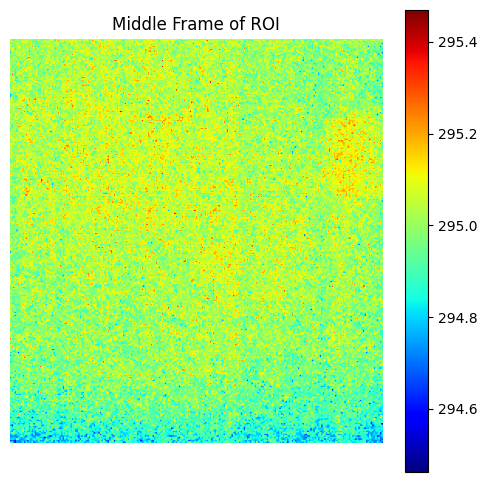

In [5]:
y1, y2, x1, x2 = 61, 323, 187, 428
image_sequence = image_sequence[y1:y2, x1:x2, :]

# image_sequence = image_sequence[5:, 115:545, :]

h, w, t = image_sequence.shape
middle_frame = image_sequence[:, :, t // 2]
plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

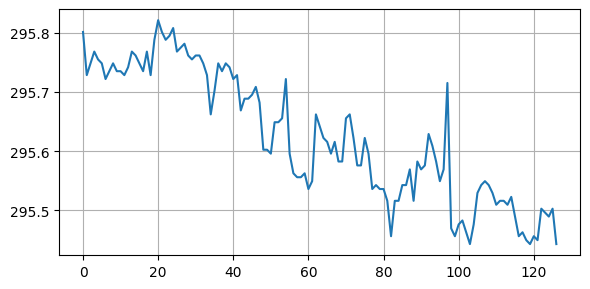

12


In [6]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 12

In [7]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

imageMatrix = (imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True))

n_components = 10
latent_dim = n_components

In [8]:
imageMatrix = imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)

U, S, Vh = np.linalg.svd(imageMatrix, full_matrices=False)

Vh = Vh[:n_components, :]

principal_comp = np.matmul(imageMatrix, Vh.T)

pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

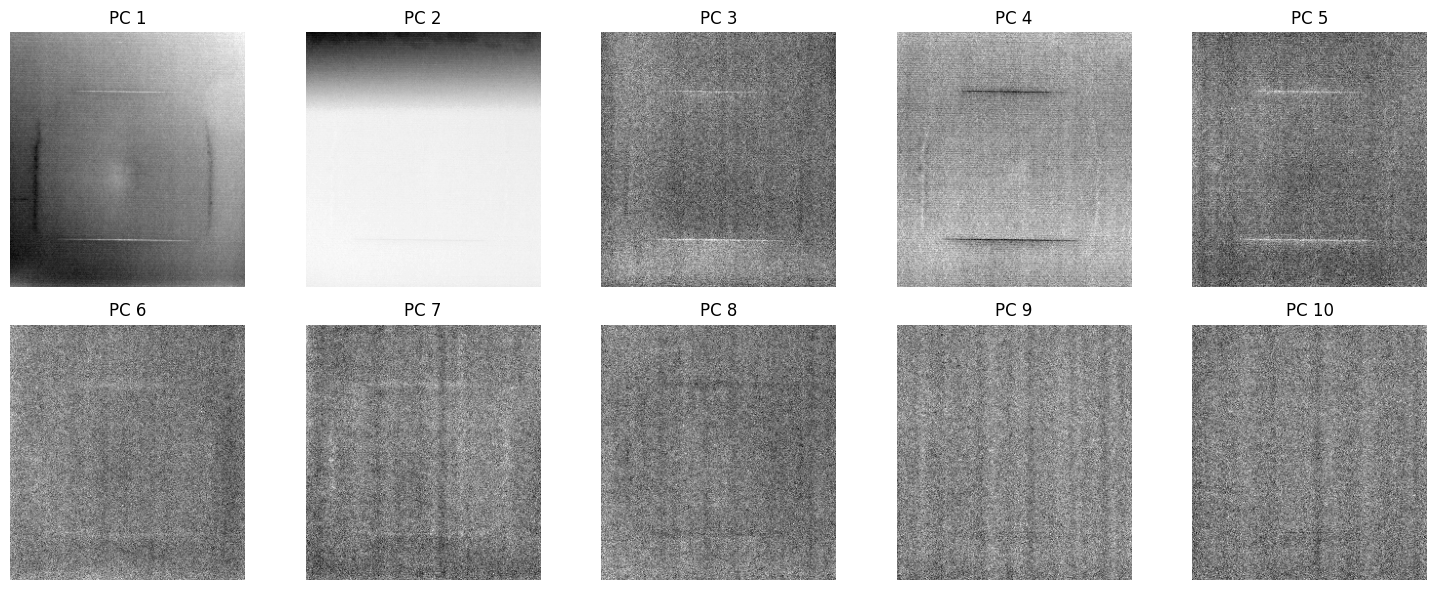

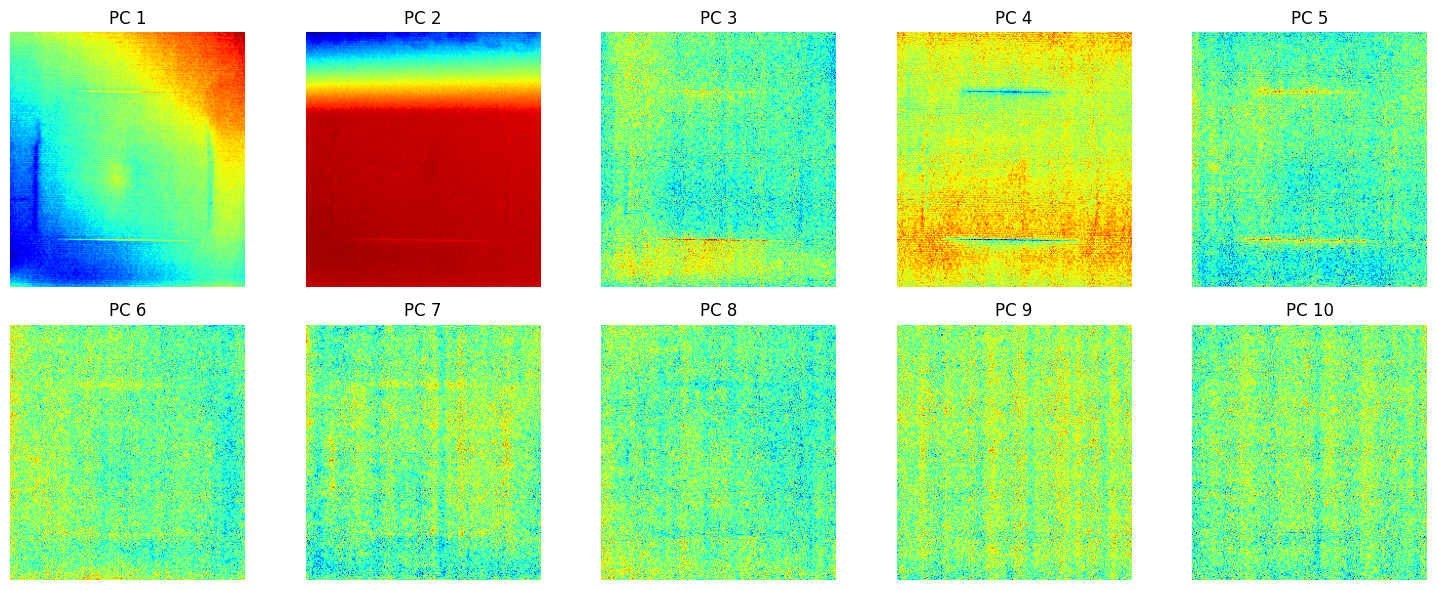

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

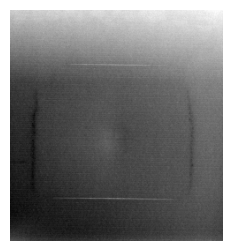

In [10]:
from sklearn.decomposition import PCA

C, H, W = pca_array.shape

flat = pca_array.reshape(C, -1).T
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(flat)

explained_var_ratio = pca.explained_variance_ratio_

pca_images = pca_result.T.reshape(n_components, H, W)

eps = 1e-8

combined = np.average(pca_images, axis=0, weights=explained_var_ratio)

combined -= combined.min()
combined /= (combined.max() + eps)
combined = (combined * 255).astype(np.uint8)

import cv2
img_rgb = cv2.cvtColor(combined, cv2.COLOR_GRAY2RGB)

import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [11]:
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

processor = AutoProcessor.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen-VL-Chat",
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
).eval()
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)

The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Loading checkpoint shards: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


In [12]:
from PIL import Image, ImageDraw

image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

save_path = "temp_image.jpg"
image.save(save_path)

In [13]:
import os, re

system = (
    "You are an expert NDT thermography inspection assistant. "
    "Your task is to detect subsurface defects in thermal images and describe their exact locations.\n\n"
    "Strict output rules:\n"
    "1) Output format must be exactly: <ref>defect</ref><box>(x1,y1),(x2,y2)</box>\n"
    "2) Coordinates must be integers. (x1,y1) is the top-left, (x2,y2) is the bottom-right of the box.\n"
    "3) If multiple defects are present, return each on a new line in the same format.\n"
    "4) If no defect is confidently found, return exactly: <ref>none</ref><box>(0,0),(0,0)</box>\n"
    "5) Do not return any explanation, reasoning, or extra text. Only the bounding boxes in the required format."
)

q1 = tokenizer.from_list_format([
    {"image": save_path},
    {"text": "Inspect the thermal image for defects. Return only the required format."}
])
_, history = model.chat(tokenizer, query=q1, history=None, system=system, use_cache=False)

ask = 'Repeat only the detected defect locations using the required format.'
resp, history = model.chat(tokenizer, ask, history=history, system=system, use_cache=False)

box_pattern = r"<ref>(.*?)</ref><box>\((\d+),(\d+)\),\((\d+),(\d+)\)</box>"
matches = re.findall(box_pattern, resp)

if not matches:
    resp, history = model.chat(tokenizer, "Repeat defect boxes in correct format: <ref>defect</ref><box>(x1,y1),(x2,y2)</box>", history=history, system=system, use_cache=False)
    matches = re.findall(box_pattern, resp)

verify = "Verify the boxes are tight and correct. If correct, repeat identically; otherwise return corrected boxes in the exact same format."
resp2, history = model.chat(tokenizer, verify, history=history, system=system, use_cache=False)
m2 = re.search(r"<ref>(.*?)</ref>\s*<box>\((\d+),\s*(\d+)\),\((\d+),\s*(\d+)\)</box>", resp2)
final_resp = resp2 if m2 else resp

image = tokenizer.draw_bbox_on_latest_picture(final_resp, history)
if image:
    image.save("qwen/" + mat_files[idx] + ".jpg")
else:
    print("no box")
print(final_resp)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<ref>defect</ref><box>(4,2),(996,995)</box>


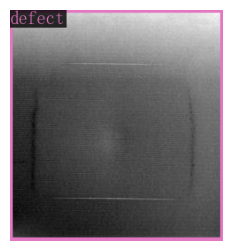

In [14]:
plt.figure(figsize=(3, 3))
plt.imshow(image.get_image())
plt.axis('off')
plt.show()